In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

rng_key = jax.random.PRNGKey(0)

## Define global parameters

In [2]:
# General parameters
dt = 0.01  # Time step [sec]

# Parameters for MPPI
N = 50  # horizon for MPPI
n_samples = 1000  # Number of samples for MPPI
Q = np.diag([100.0, 10.0, 100.0, 10.0, 10.0, 10.0])  # Weight for state
QT = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0]) * N / 6  # Weight for terminal state
R = np.diag([0.25, 0.01])  # Weight for control
q_ref = np.array([5.0, 0.0, 5.0, 0.0, 0.0, 0.0])  # Reference state
alpha = 0.1  # Tunable parameter for CBF constraint in MPPI, ranged (0, 1]
ctrl_noise_scale = [5, 2]

# Simulation parameters
T = 6  # Total time for simulation
ratio_sim_mppi = 10  # how fast simulator run faster than mppi controller

# Quadrotor parameters
m_q = 1.0 # kg
I_xx = 0.1 # kg.m^2
l_q = 0.3 # m, length of the quadrotor
g = 9.81

## Define functions for visualization

In [3]:
def plot_simulation_result(states):
  plt.figure()
  plt.gca().set_aspect('equal', adjustable='box')
  ys = [s[0] for s in states]
  zs = [s[2] for s in states]
  phis = [s[4] for s in states]
  # Generate circle for CBF
  circle1 = plt.Circle((2, 2), np.sqrt(1), color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
  circle2 = plt.Circle((3, 5), np.sqrt(1), color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
  plt.gca().add_artist(circle1)
  plt.gca().add_artist(circle2)

  # Plot the trajectory
  plt.scatter(ys, zs)

  # Plot quadrotor pose
  y_ = [(y-l_q*np.cos(phi), y+l_q*np.cos(phi)) for (y, phi) in zip(ys[::10], phis[::10])]
  z_ = [(z-l_q*np.sin(phi), z+l_q*np.sin(phi)) for (z, phi) in zip(zs[::10], phis[::10])]
  for yy, zz in zip(y_, z_):
    plt.plot(yy, zz, marker="o", color="r", alpha=0.5)

  # plot start and end point
  plt.scatter(0.0, 0.0, s=200, color="green", alpha=0.75, label="init. position")
  plt.scatter(5.0, 5.0, s=200, color="purple", alpha=0.75, label="target position")

  plt.grid(); plt.show()

def get_predicted_trajecotories(current_state, control_sequence):
  predicted_state = [current_state]

  for ctrl in control_sequence:
    next_state = dynamics(predicted_state[-1], ctrl)
    predicted_state.append(next_state.copy())
  return np.array(predicted_state)

def animate_simulation(states, sampled_us=[], optimal_us=None):
    def update(frame, states):
        plt.gca().cla()  # Clear the current axes

        # Set axis limits
        plt.xlim([-1, 7])
        plt.ylim([-1, 7])

        # Set aspect ratio to be equal, so each cell will be square-shaped
        plt.gca().set_aspect('equal', adjustable='box')

        # Generate circle for CBF
        circle1 = plt.Circle((2, 2), np.sqrt(1), color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
        circle2 = plt.Circle((3, 5), np.sqrt(1), color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
        plt.gca().add_artist(circle1)
        plt.gca().add_artist(circle2)

        # Plot MPPI trajectories
        if len(sampled_us) > 0:
          # pred_trajs = [get_predicted_trajecotories(states[frame], sampled_us[frame][i]) for i in range(len(sampled_us))]
          num_trajs_plotted = np.minimum(50,  sampled_us[frame].shape[0])  # plot maximum 50 trajs per step
          for idx in range(num_trajs_plotted):
            pred_traj = get_predicted_trajecotories(states[frame], sampled_us[frame][idx])
            x_pos, y_pos = pred_traj[:, 0], pred_traj[:, 2]
            plt.plot(x_pos, y_pos, color="k", alpha=0.1)

        # plot optimal predicted trajectory
        if optimal_us is not None:
          opt_pred_traj = get_predicted_trajecotories(states[frame], optimal_us[frame])
          x_pos, y_pos = opt_pred_traj[:, 0], opt_pred_traj[:, 2]
          plt.plot(x_pos, y_pos, color="orange", alpha=0.8, label="optimized traj.")

        y, _, z, _, phi, _ = states[frame]
        ys = [s[0] for s in states]
        zs = [s[2] for s in states]
        phis = [s[4] for s in states]

        # Plot the trajectory up to the current frame
        plt.plot([state[0] for state in states[:frame+1]], [state[2] for state in states[:frame+1]], '-o', markersize=4, alpha=0.5)

        # Plot the orientation at the current frame
        plt.plot((y-0.3*np.cos(phi), y+0.3*np.cos(phi)), (z-0.3*np.sin(phi), z+0.3*np.sin(phi)), marker="o", color="r", alpha=0.5)

        # plot start and end point
        plt.scatter(0.0, 0.0, s=200, color="green", alpha=0.75, label="init. position")
        plt.scatter(5.0, 5.0, s=200, color="purple", alpha=0.75, label="target position")

        plt.title('Simulation Result')
        plt.xlabel('Y Position')
        plt.ylabel('Z Position')
        plt.grid(True)
        plt.legend(loc="upper left")

    fig = plt.figure(figsize=(6, 6))
    anim = FuncAnimation(fig, update, frames=len(states), fargs=(states,), interval=100, blit=False)
    anim.save('simulation.gif', writer='imagemagick')


## Define 2D planar quadrotor models

The model of the planar quadrotor is from an [Aerial Robitics lecture](https://www.coursera.org/lecture/robotics-flight/2-d-quadrotor-control-kakc6) on couyrsera.

The state of the planar quadrotor is defined as

\begin{equation}
(y, \dot{y}, z, \dot{z}, \phi, \dot{\phi})
\end{equation}
where:
- $(y, z)$ is the position.
- $\phi$ is the roll angle.

The control input consists of:
- The total thrust $u_1$.
- The torque provided by the rotors $u_2$.

The dynamics of the planar quadrotor are described by the following equations:
$$
\begin{align}
    \ddot{y} &= \frac{-u_1}{m_q}\cdot{\sin(\phi)} \\
    \ddot{z} &= -g + \frac{u_1}{m_q}\cdot{\cos(\phi)} \\
    \ddot{\phi} &= \frac{u_2}{I_{xx}}
\end{align}
$$

where $m_q$ is the mass of the quadrotor, $I_{xx}$ is the inertia moment of the quadrotor, and $g$ is the gravity.

In [4]:
def dynamics(state, control, dt=dt, m_q=m_q, g=g, I_xx=I_xx):
    """
    Calculate the next state of the system based on the current state and control inputs.
    :param u1: Thrust input
    :param u2: Moments input
    :return: New state as a tuple (y_ddot, z_ddot, phi_ddot)
    """
    y, y_dot, z, z_dot, phi, phi_dot = state
    u1, u2 = control
    # Quadrotor dynamics
    y_ddot = -u1 * np.sin(phi) / m_q
    z_ddot = -g + u1 * np.cos(phi) / m_q
    phi_ddot = u2 / I_xx

    next_state = state + np.array([y_dot, y_ddot, z_dot, z_ddot, phi_dot, phi_ddot]) * dt
    return next_state

@jax.jit
def jax_dynamics(state, control, dt=dt, m_q=m_q, g=g, I_xx=I_xx):
    """
    Simplified kinematic bicycle car dynamics with JAX-compatible code.
    """
    y, y_dot, z, z_dot, phi, phi_dot = state
    u1, u2 = control
    # Quadrotor dynamics
    y_ddot = -u1 * jnp.sin(phi) / m_q
    z_ddot = -g + u1 * jnp.cos(phi) / m_q
    phi_ddot = u2 / I_xx

    next_state = state + jnp.array([y_dot, y_ddot, z_dot, z_ddot, phi_dot, phi_ddot]) * dt
    return next_state

## Define MPPI

In [5]:
# MPPI
@jax.jit
def jax_mppi(state, U, rng_key, n_samples=n_samples, N=N, q_ref=q_ref, Q=Q, QT=QT, R=R, cbf_cost_weight=1e4, pose_constraints_weight=1e4, dcbf_alpha=alpha):
    def h1_x(x):
      # barrier function
      h = jnp.sqrt((x[0] - 2.0)**2 + (x[2] - 2.0)**2) - (1 + l_q)  # collision avoidance
      return h

    def h2_x(x):
      # barrier function
      h = jnp.sqrt((x[0] - 3.0)**2 + (x[2] - 5.0)**2) - (1 + l_q)  # collision avoidance
      return h

    def pose_constraint(x):
      # to have the quadrotor stay near horizontal
      return jnp.clip(jnp.abs(x[4]) - np.deg2rad(30), 0, np.inf)

    def scan_fn(carry, u):
        cost, sim_state = carry
        # stage cost
        new_cost = cost + jnp.dot((sim_state - q_ref), jnp.dot(Q, (sim_state - q_ref))) + jnp.dot(u, jnp.dot(R, u))
        new_state = jax_dynamics(sim_state, u)

        # CBF cost
        barrier_value, next_barrier_value =  h1_x(sim_state), h1_x(new_state)
        cbf_cost1 = -next_barrier_value + dcbf_alpha * barrier_value
        cbf_cost1 =  cbf_cost_weight * jnp.clip(cbf_cost1, 0.0, np.inf)
        barrier_value, next_barrier_value =  h2_x(sim_state), h2_x(new_state)
        cbf_cost2 = -next_barrier_value + dcbf_alpha * barrier_value
        cbf_cost2 =  cbf_cost_weight * jnp.clip(cbf_cost2, 0.0, np.inf)
        new_cost += cbf_cost1 + cbf_cost2

        # pose constraints penalty
        new_cost += pose_constraints_weight * pose_constraint(new_state)
        return (new_cost, new_state), None

    def single_sample_cost(rng_subkey):
        noise = 1.0 * jax.random.normal(rng_subkey, (N, 2))
        noise_scaled = noise * jnp.array(ctrl_noise_scale)
        u_seq = U + noise_scaled
        cost_and_state, _ = jax.lax.scan(scan_fn, (0.0, state), u_seq)
        cost = cost_and_state[0]

        # Calculate terminal cost
        terminal_state = cost_and_state[1]
        terminal_cost = jnp.dot((terminal_state - q_ref), jnp.dot(QT, (terminal_state - q_ref)))
        cost += terminal_cost
        return (cost, terminal_state), u_seq

    rng_keys = jax.random.split(rng_key, n_samples)
    all_costs_and_state, all_seqs = jax.vmap(single_sample_cost)(rng_keys)

    # get optimal control input
    final_costs = all_costs_and_state[0]
    temperature = 1.0
    exp_cost =jnp.exp(temperature * (jnp.min(final_costs) - final_costs))
    denom = jnp.sum(exp_cost) + 1e-7
    best_U =  jnp.sum(exp_cost[..., None, None] * all_seqs, axis=0) / denom

    new_U = jnp.roll(best_U, shift=-1, axis=0)
    new_U = new_U.at[-1].set(new_U[-2])
    return best_U[0], new_U, all_seqs

## Run closed-loop simulation of MPPI with CBF cost

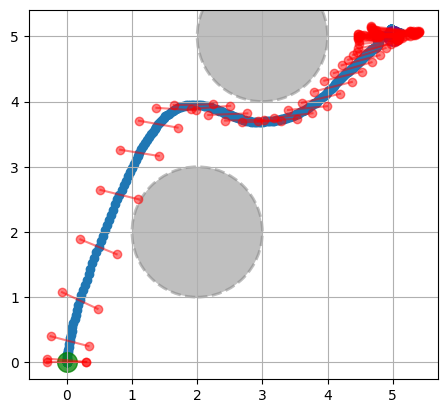

CPU times: user 3.8 s, sys: 694 ms, total: 4.49 s
Wall time: 2.63 s


In [6]:
%%time
# Initialize state and control
state = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # [y, y_dot, z, z_dot, phi, phi_dot]
states = [state]  # `states` is a list containing the states over time
U = np.zeros((N, 2))  # Initial control sequence for MPPI

# Closed-loop simulation
global_U = U.copy()
sim_state = state.copy()
mppi_sampled_us = [np.zeros((n_samples, N, 2))]
global_Us = [global_U.copy()]
for t in np.arange(0, T, dt):
    rng_key, subkey = jax.random.split(rng_key)
    u_mppi_cbf, global_U, sampled_us = jax_mppi(sim_state, global_U, subkey, cbf_cost_weight=1e8, Q=Q, QT=QT, R=R)  # Set cbf_cost_weight as a large value
    for i in range(ratio_sim_mppi):
        sim_state = jax_dynamics(sim_state, u_mppi_cbf, dt=dt/ratio_sim_mppi)
    states.append(sim_state)
    mppi_sampled_us.append(sampled_us)
    global_Us.append(global_U.copy())

# Visualize result
states = np.array(states)  # Convert list of states to numpy array for analysis or plotting
plot_simulation_result(states)

## Generate animation

GIF saved as `simulation.gif`

In [7]:
# reduce size of outputs to save time for gif generation
tmp_states, tmp_mppi_sampled_us, tmp_global_Us = states[::5], mppi_sampled_us[::5], global_Us[::5]

MovieWriter imagemagick unavailable; using Pillow instead.


CPU times: user 25.8 s, sys: 141 ms, total: 26 s
Wall time: 26.2 s


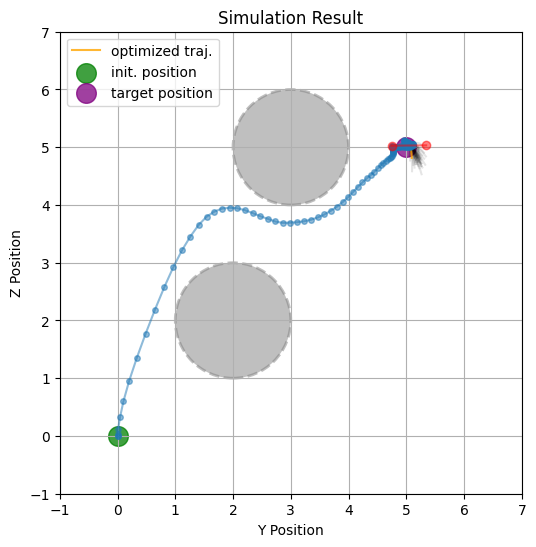

In [8]:
%%time
anim = animate_simulation(tmp_states, tmp_mppi_sampled_us, tmp_global_Us)

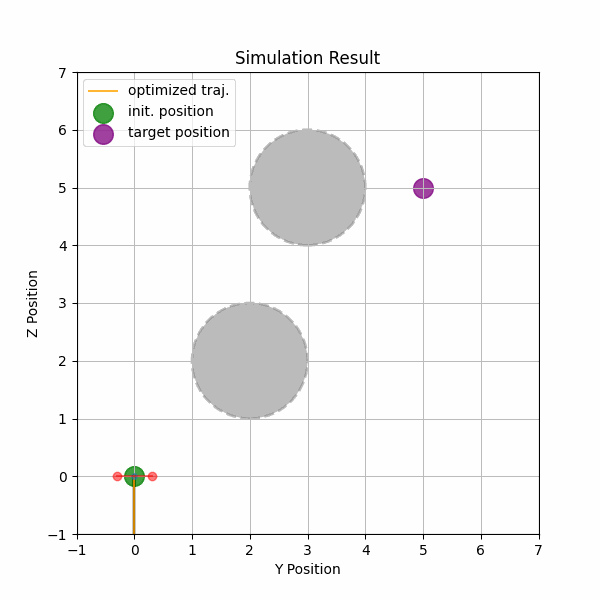

In [9]:
from IPython.display import Image
Image(open('simulation.gif','rb').read())